In [1]:
import numpy as np
import cv2 
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Conv2D,MaxPooling2D,UpSampling2D,concatenate,BatchNormalization,Conv2DTranspose
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Add,Reshape,multiply,Lambda,add,ReLU,Activation,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-08-17 01:08:05.209195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 01:08:05.209350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 01:08:05.344131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def yolo_to_mask(img_path, label_path, output_path, img_size):
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_name, x, y, width, height = map(float, line.strip().split())
            x = int(x * w)
            y = int(y * h)
            width = int(width * w)
            height = int(height * h)
            x1 = int(x - width / 2)
            y1 = int(y - height / 2)
            x2 = int(x + width / 2)
            y2 = int(y + height / 2)
            cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

    mask = cv2.resize(mask, img_size)
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)

    output_file = os.path.join(output_path, os.path.basename(img_path).replace('.png', '.png'))
    cv2.imwrite(output_file, mask * 255)
    #print("Done")



In [3]:
img_dir = "/kaggle/input/lu3m6tgt/LU3M6TGT_yolo_format/train/images"
label_dir = "/kaggle/input/lu3m6tgt/LU3M6TGT_yolo_format/train/labels"
img_size = (128, 128)
output_dir = "/kaggle/working/mask_images"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])
label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.txt')])
j=0
for img_path, label_path in zip(img_paths, label_paths):
    yolo_to_mask(img_path, label_path, output_dir, img_size)
    if(j%1000==0):
        print("Done")
    j=j+1


Done
Done
Done
Done
Done
Done
Done
Done
Done


In [4]:
def load_image(image_path,mask_path,img_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img,img_size)
    img = img/255
    
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,img_size)
    mask = mask/255
    mask = np.expand_dims(mask,axis=-1)
    
    return img,mask
def load_datasets(img_dir,mask_dir,image_size):
    
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_dir,f) for f in os.listdir(mask_dir) if f.endswith('.png')])
    
    imgs,masks = [],[]
    
    for img_path,mask_path in zip(img_paths,mask_paths):
        img,mask = load_image(img_path,mask_path,image_size)
        imgs.append(img)
        masks.append(mask)
    return np.array(imgs),np.array(masks)

In [5]:
image_size = (128,128)

image_path = '/kaggle/input/lu3m6tgt/LU3M6TGT_yolo_format/train/images'
mask_path = "/kaggle/working/mask_images"

imgs , masks = load_datasets(image_path,mask_path,image_size)

In [6]:
imgs.shape

(8756, 128, 128, 3)

### Model Building

In [7]:
def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w, h, c = input_tensor.shape[1], input_tensor.shape[2], input_tensor.shape[3]
    
    for bin_size in bin_sizes:
        x = Lambda(lambda z: tf.image.resize(z, (bin_size, bin_size)))(input_tensor)
        x = Conv2D(c, (1, 1), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)  # Added Batch Normalization
        x = Lambda(lambda z: tf.image.resize(z, (w, h)))(x)
        concat_list.append(x)
    
    return concatenate(concat_list)

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (2, 2), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    f = add([theta_x, phi_g])
    f = ReLU()(f)
    psi_f = Conv2D(1, (1, 1), padding='same')(f)
    psi_f = Activation('sigmoid')(psi_f)
    rate = multiply([x, psi_f])
    return rate

def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    return multiply([input_tensor, se])

def ResBlock(x, filters, kernel_size=3, strides=1, reg=0.001, use_se=True):
    y = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_regularizer=l2(reg))(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(reg))(y)
    y = BatchNormalization()(y)
    if use_se:  # Added Squeeze-and-Excitation block
        y = squeeze_excite_block(y)
    if strides != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_regularizer=l2(reg))(x)
    return ReLU()(add([x, y]))

def unet(image_size):
    inputs = Input(shape=image_size + (3,))
    
    # Encoder
    c1 = ResBlock(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.4)(p1)  # Increased dropout to 0.4
    
    c2 = ResBlock(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.4)(p2)  # Increased dropout to 0.4
    
    c3 = ResBlock(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.4)(p3)  # Increased dropout to 0.4
    
    c4 = ResBlock(p3, 512)
    ppm = pyramid_pooling_block(c4, [1, 2, 3, 6])
    
    # Decoder
    g1 = UpSampling2D((2, 2))(ppm)
    att1 = attention_block(c3, g1, 128)
    u1 = concatenate([g1, att1])
    c5 = ResBlock(u1, 256)
    
    g2 = UpSampling2D((2, 2))(c5)
    att2 = attention_block(c2, g2, 64)
    u2 = concatenate([g2, att2])
    c6 = ResBlock(u2, 128)
    
    g3 = UpSampling2D((2, 2))(c6)
    att3 = attention_block(c1, g3, 32)
    u3 = concatenate([g3, att3])
    c7 = ResBlock(u3, 64)
    
    output = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = Model(inputs, output)
    
    # Compile with an advanced optimizer
    model.compile(optimizer=AdamW(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
model = unet(image_size=image_size)
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
re_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        256 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]  

 Total params: 15,102,692 (57.61 MB)

 Trainable params: 15,092,964 (57.58 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [9]:
# len(imgs)

type(imgs)

numpy.ndarray

In [10]:
def splits(dataset,Train_ratio,test_rat):
    size = len(dataset)
    train_dataset = dataset[0:int(size*Train_ratio)]


    #val_dataset = dataset[]

#     val_dataset = val_dataset.take(int(val_rat*size))


    test_dataset = dataset[int(size*Train_ratio):]

    
    return train_dataset,test_dataset

In [11]:
TRAIN_RAT = 0.8
TEST_RAT = 0.2

train_image,test_image = splits(imgs,TRAIN_RAT,TEST_RAT)
train_mask,test_mask = splits(masks,TRAIN_RAT,TEST_RAT)

In [12]:
history = model.fit(train_image,train_mask,epochs=80,batch_size=16,validation_split=0.1,callbacks=[es,re_lr])

Epoch 1/80


I0000 00:00:1723857252.696423      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


394/394 ━━━━━━━━━━━━━━━━━━━━ 375s 668ms/step - accuracy: 0.8374 - loss: 1.6961 - val_accuracy: 0.8100 - val_loss: 0.7270 - learning_rate: 0.0010
Epoch 2/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 140s 355ms/step - accuracy: 0.8614 - loss: 0.3477 - val_accuracy: 0.8577 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 3/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 139s 353ms/step - accuracy: 0.8656 - loss: 0.3233 - val_accuracy: 0.8406 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 4/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 139s 353ms/step - accuracy: 0.8691 - loss: 0.3166 - val_accuracy: 0.8296 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 5/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 139s 352ms/step - accuracy: 0.8721 - loss: 0.3080 - val_accuracy: 0.8514 - val_loss: 0.3369 - learning_rate: 0.0010
Epoch 6/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 138s 350ms/step - accuracy: 0.8760 - loss: 0.3035 - val_accuracy: 0.8531 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 7/80
394/394 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.8753 

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score, average_precision_score, roc_curve, roc_auc_score, precision_recall_curve
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(int)  # Binarize predictions
    y_true = (y_true > threshold).astype(int)  # Ensure ground truth is binary as well

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Ensure both y_true and y_pred are binary
    if len(np.unique(y_true_flat)) > 2 or len(np.unique(y_pred_flat)) > 2:
        raise ValueError("Ensure both y_true and y_pred are binary arrays")

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel()

    # Calculate metrics
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    iou = jaccard_score(y_true_flat, y_pred_flat)

    # Calculate mAP
    ap = average_precision_score(y_true_flat, y_pred_flat)

    metrics = {
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Mean IoU': iou,
        'mAP': ap
    }

    # Visualizations
    plot_confusion_matrix(tn, fp, fn, tp)
    plot_roc_curve(y_true_flat, y_pred_flat)
    plot_precision_recall_curve(y_true_flat, y_pred_flat)

    return metrics

def plot_confusion_matrix(tn, fp, fn, tp):
    cm = np.array([[tn, fp], [fn, tp]])
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % ap)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

In [14]:
y_pred = model.predict(test_image)

2024-08-17 04:02:44.295650: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,2816,32,32]{3,2,1,0}, f32[256,2816,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 04:02:44.333695: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.038165337s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,2816,32,32]{3,2,1,0}, f32[256,2816,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha"

55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 884ms/step


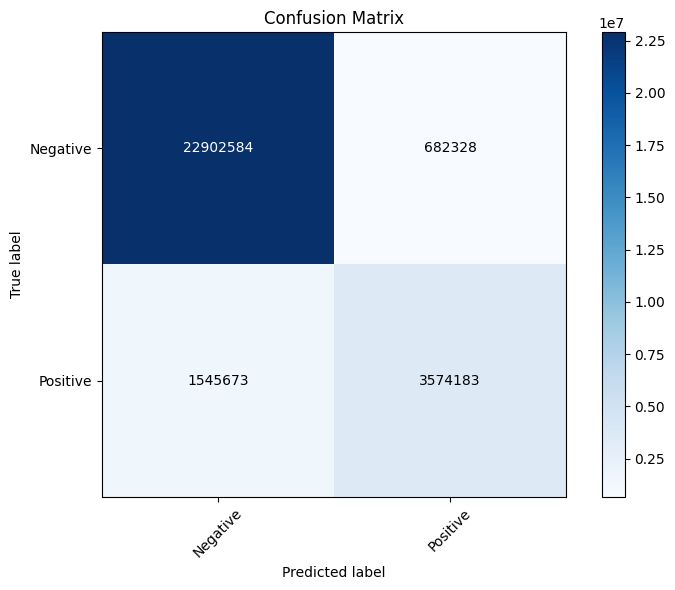

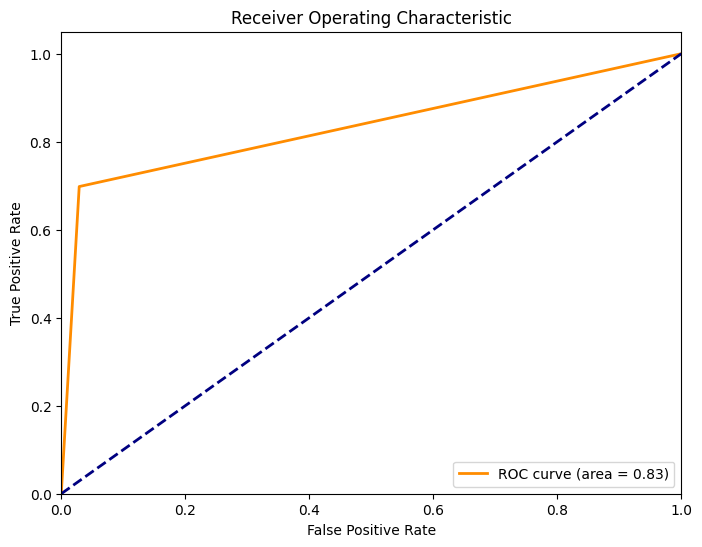

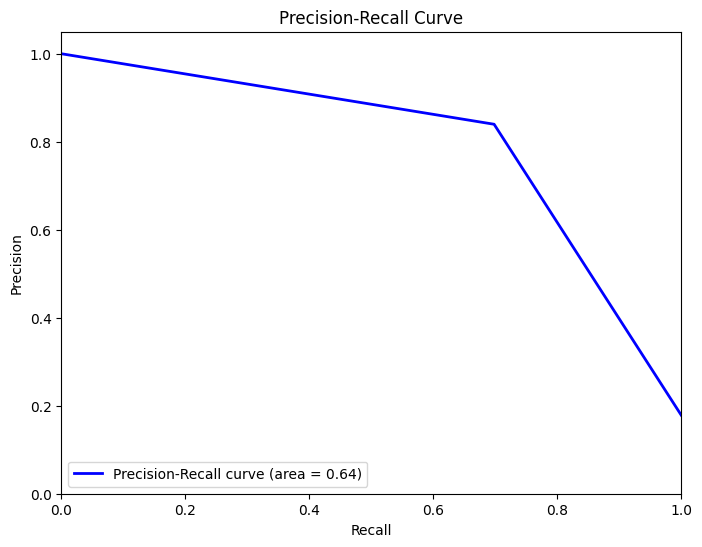

In [15]:
metrics = calculate_metrics(test_mask, y_pred)

In [16]:
print(metrics)

{'True Positives': 3574183, 'False Positives': 682328, 'True Negatives': 22902584, 'False Negatives': 1545673, 'Precision': 0.8396978182365792, 'Recall': 0.6981022513133182, 'F1 Score': 0.7623812079881259, 'Mean IoU': 0.6160064899699838, 'mAP': 0.6400421936502793}


In [17]:
print(metrics)

{'True Positives': 3574183, 'False Positives': 682328, 'True Negatives': 22902584, 'False Negatives': 1545673, 'Precision': 0.8396978182365792, 'Recall': 0.6981022513133182, 'F1 Score': 0.7623812079881259, 'Mean IoU': 0.6160064899699838, 'mAP': 0.6400421936502793}


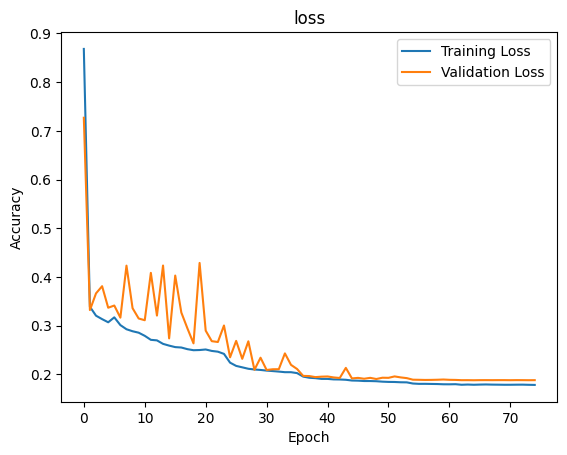

In [18]:
plt.plot(history.history['loss'] , label = "Training Loss")
plt.plot(history.history['val_loss'] , label = "Validation Loss")
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()


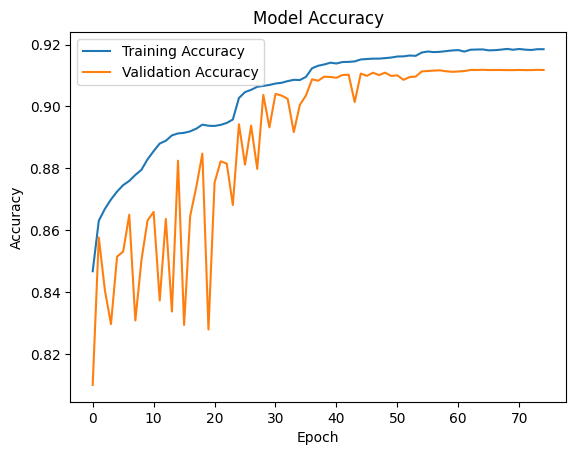

In [19]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


In [20]:
def process_image(image,black_value):
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY_INV)
    tot_pix = im.size
    dark_pix = np.sum(thresh == 255)
    percentage = (dark_pix / tot_pix) * 100

    
    if percentage > black_value:
        beta = 45
        bright = cv2.convertScaleAbs(image,beta=beta)
        
        contrast = 1.3
        contr_image = cv2.convertScaleAbs(bright,alpha=contrast,beta=0)
        
        lab = cv2.cvtColor(contr_image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = cv2.equalizeHist(l)
        adjusted_image = cv2.merge((l, a, b))
        final_image = cv2.cvtColor(adjusted_image, cv2.COLOR_LAB2BGR)
        
        return final_image
    
    return image
        

In [21]:
def draw_circle(image,mask,size):
    mask = cv2.resize(mask,(size[1],size[0]))
    contour,_ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    i=1
    for con in contour:
        (x,y),rad = cv2.minEnclosingCircle(con)
        center = (int(x),int(y))
        rad = int(rad)
        
        if rad>15:
            cv2.circle(image,center,rad,(0,255,0),2)
            cv2.putText(image, f'crater {i}', center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            i=i+1
    return image

In [22]:
def slide(image, step, kwin):
    for y in range(0, image.shape[0] - kwin[1] + 1, step[1]):
        for x in range(0, image.shape[1] - kwin[0] + 1, step[0]):
            yield (x, y, image[y:y+kwin[1], x:x+kwin[0]])

In [23]:
def predict_image(model, image, kwin, step):
    output_image = np.zeros(image.shape[:2])
    count_mat = np.zeros(image.shape[:2])
    mask_image = np.zeros_like(output_image)
    
    for (x, y, win) in slide(image, step, kwin):
        patch = win
        if patch.shape[:2] == kwin:
            patch_ = cv2.resize(patch, (128, 128))
            prediction = model.predict(np.expand_dims(patch_, axis=0), verbose=0)
            prediction_resized = cv2.resize(prediction.squeeze(), (kwin[1], kwin[0]))
            output_image[y:y+kwin[1], x:x+kwin[0]] += prediction_resized
            count_mat[y:y+kwin[1], x:x+kwin[0]] += 1
            mask_image[y:y+kwin[1], x:x+kwin[0]] = np.maximum(mask_image[y:y+kwin[1], x:x+kwin[0]], prediction_resized)
    
    output_image = np.divide(output_image, count_mat, out=np.zeros_like(output_image), where=count_mat!=0)
    return output_image, mask_image

In [24]:
ohrc_image = cv2.imread('/kaggle/input/ohrc-data/ch2_ohr_ncp_20240406T0052354542_b_brw_d18.png')/255
# kwin = (128,128)
# step = (64,64)
kwin=(750,750)
step=(350,320)
# ohrc_image_1 = process_image(ohrc_image,78)
out,pred = predict_image(model,ohrc_image,kwin,step)


True

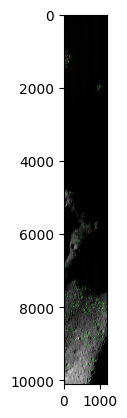

In [25]:
pred = (pred>0.7).astype(np.uint8) * 255

res_image = draw_circle(ohrc_image,pred,ohrc_image.shape[:2])
ohrc_image_ = (ohrc_image*255).astype(np.uint8)
res_image = draw_circle(ohrc_image_, pred, ohrc_image.shape[:2])
plt.imshow(cv2.cvtColor(res_image,cv2.COLOR_BGR2RGB))
cv2.imwrite("crater.jpg",cv2.cvtColor(res_image,cv2.COLOR_BGR2RGB))

In [26]:
ohrc_image_2 = cv2.imread('/kaggle/input/ohrc-data-2/ch2_ohr_ncp_20240403T1750244263_b_brw_d18.png')/255
# kwin = (128,128)
# step = (64,64)
kwin=(750,750)
step=(350,320)
# ohrc_image_2_ = process_image(ohrc_image_2,76)
out_2,pred_2 = predict_image(model,ohrc_image_2,kwin,step)


True

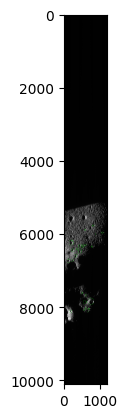

In [27]:
pred_2_2 = (pred_2>0.7).astype(np.uint8) * 255

res_image_2 = draw_circle(ohrc_image_2,pred_2_2,ohrc_image_2.shape[:2])
ohrc_image_2_2 = (ohrc_image_2*255).astype(np.uint8)
res_image_2 = draw_circle(ohrc_image_2_2, pred_2_2, ohrc_image_2_2.shape[:2])
plt.imshow(cv2.cvtColor(res_image_2,cv2.COLOR_BGR2RGB))
cv2.imwrite("crater_2.jpg",cv2.cvtColor(res_image_2,cv2.COLOR_BGR2RGB))

(985, 985, 3)
(985, 985)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


True

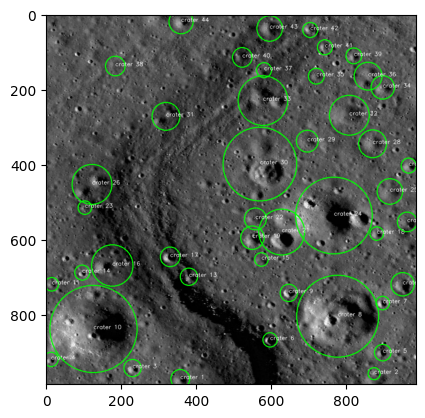

In [28]:
new_image = cv2.imread('/kaggle/input/crater/3.jpg')
print(new_image.shape)
print(new_image.shape[:2])
size = new_image.shape[:2]
new_image_ = cv2.resize(new_image,(128,128))
new_image_ = np.expand_dims(new_image_,axis=0)/255

predict_mask = model.predict(new_image_)[0]

predict_mask = (predict_mask > 0.88).astype(np.uint8) * 255

res_image = draw_circle(new_image,predict_mask,size)
plt.imshow(cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB))
cv2.imwrite("ppt.jpg",cv2.cvtColor(res_image,cv2.COLOR_BGR2RGB))